<a href="https://colab.research.google.com/github/PozzOver13/learning/blob/main/stats_and_probability/20241218_pymc_hierachical_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PYMC - Hierarchical Models
https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html

gaussian processes on spatial data
https://www.pymc-labs.com/blog-posts/spatial-gaussian-process-01/
https://marcgenton.github.io/2017.JJG.StatSci.pdf


In [63]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr

warnings.filterwarnings("ignore", module="scipy")

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.19.1


In [64]:
RANDOM_SEED = 8924
az.style.use("arviz-darkgrid")

In [65]:
try:
    srrs2 = pd.read_csv(os.path.join("..", "data", "srrs2.dat"))
except FileNotFoundError:
    srrs2 = pd.read_csv(pm.get_data("srrs2.dat"))

srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

In [66]:
srrs_mn.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county
5080,5081,MN,MN,27,55735,5,1,1,3,N,...,930,12088,12288,2.2,9.7,1146.499190,1,0,1,AITKIN
5081,5082,MN,MN,27,55748,5,1,0,4,Y,...,1615,11888,12088,2.2,14.5,471.366223,0,0,1,AITKIN
5082,5083,MN,MN,27,55748,5,1,0,4,Y,...,1515,20288,21188,2.9,9.6,433.316718,0,0,1,AITKIN
5083,5084,MN,MN,27,56469,5,1,0,4,Y,...,1410,122987,123187,1.0,24.3,461.623670,0,0,1,AITKIN
5084,5085,MN,MN,27,55011,3,1,0,4,Y,...,600,12888,13088,3.1,13.8,433.316718,0,0,3,ANOKA


In [67]:
try:
    cty = pd.read_csv(os.path.join("..", "data", "cty.dat"))
except FileNotFoundError:
    cty = pd.read_csv(pm.get_data("cty.dat"))

srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

In [68]:
srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

In [69]:
srrs_mn.county = srrs_mn.county.map(str.strip)
county, mn_counties = srrs_mn.county.factorize()
srrs_mn["county_code"] = county
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

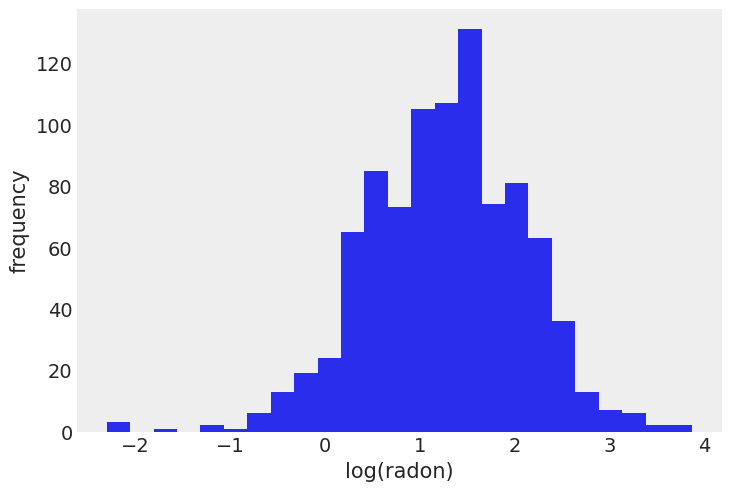

In [70]:
srrs_mn.log_radon.hist(bins=25, grid=False)
plt.xlabel("log(radon)")
plt.ylabel("frequency");

## Pooled Model

In [71]:
with pm.Model() as pooled_model:
    floor_ind = pm.MutableData("floor_ind", floor_measure, dims="obs_id")

    alpha = pm.Normal("alpha", 0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.Exponential("sigma", 5)

    theta = alpha + beta * floor_ind

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

/usr/local/lib/python3.10/dist-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


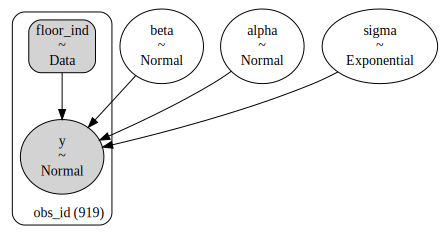

In [72]:
pm.model_to_graphviz(pooled_model)

In [73]:
with pooled_model:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

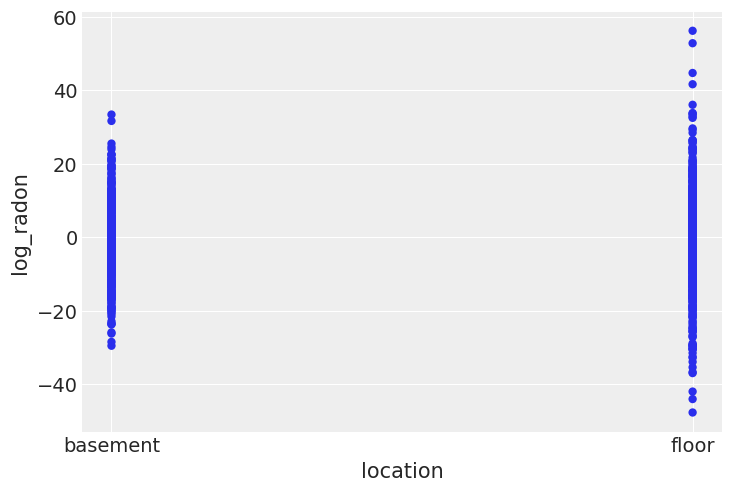

In [74]:
prior = prior_checks.prior.squeeze(drop=True)

(
    xr.concat((prior["alpha"], prior["alpha"] + prior["beta"]), dim="location")
    .rename("log_radon")
    .assign_coords(location=["basement", "floor"])
    .plot.scatter(x="location",
                  y="log_radon",
                  edgecolors="none")
)


In [75]:
with pooled_model:
    pooled_trace = pm.sample(random_seed=RANDOM_SEED)

Output()

Output()

In [76]:
az.summary(pooled_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.36,0.03,1.31,1.42,0.0,0.0,2380.53,1620.38,1.0
beta,-0.59,0.07,-0.72,-0.47,0.0,0.0,2479.06,1663.72,1.0
sigma,0.79,0.02,0.75,0.82,0.0,0.0,2708.11,1461.29,1.0


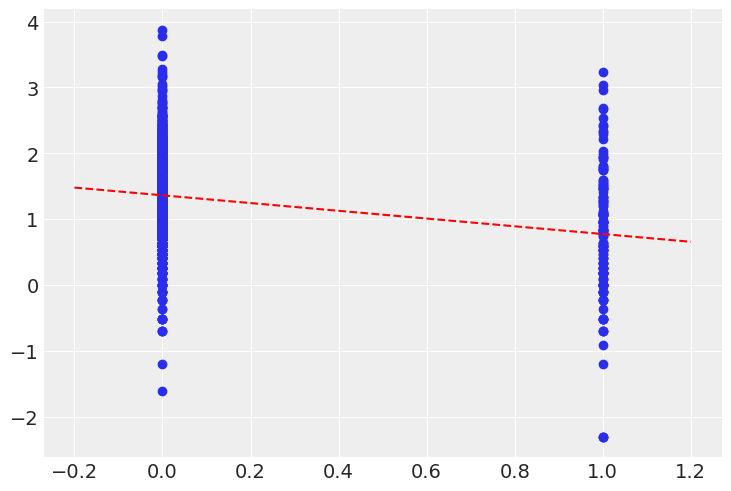

In [77]:
post_mean = pooled_trace.posterior.mean(dim=("chain", "draw"))

plt.scatter(srrs_mn.floor, np.log(srrs_mn.activity + 0.1))
xvals = xr.DataArray(np.linspace(-0.2, 1.2))
plt.plot(xvals, post_mean["beta"] * xvals + post_mean["alpha"], "r--");

## Unpooled Model

In [78]:
coords = {"county": mn_counties}

with pm.Model(coords=coords) as unpooled_model:
    floor_ind = pm.MutableData("floor_ind", floor_measure, dims="obs_id")

    alpha = pm.Normal("alpha", 0, sigma=10, dims="county")
    beta = pm.Normal("beta", 0, sigma=10)
    sigma = pm.Exponential("sigma", 1)

    theta = alpha[county] + beta * floor_ind

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

/usr/local/lib/python3.10/dist-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


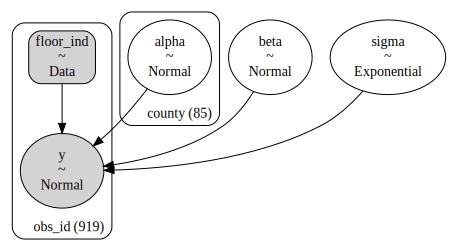

In [79]:
pm.model_to_graphviz(unpooled_model)

In [80]:
with unpooled_model:
    unpooled_trace = pm.sample(random_seed=RANDOM_SEED)

Output()

Output()

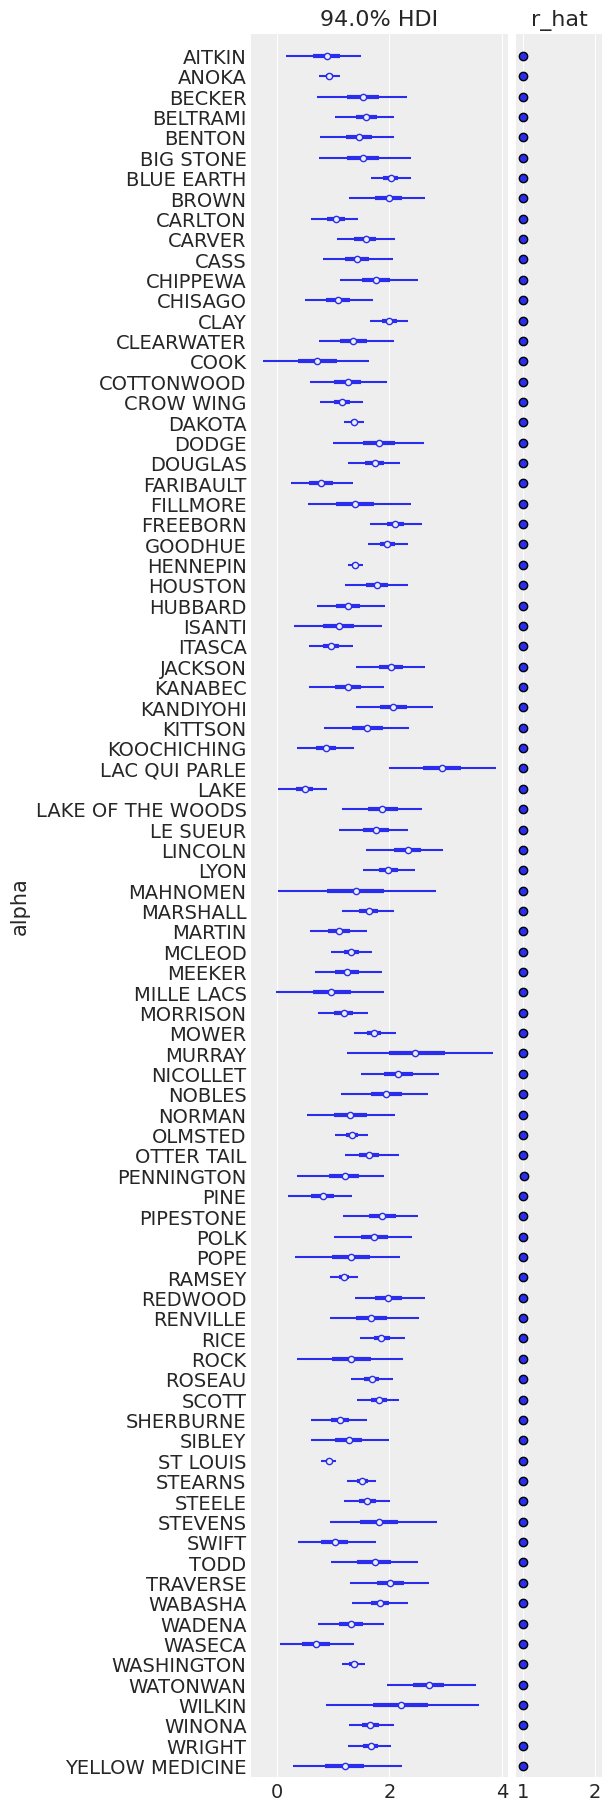

In [81]:
ax = az.plot_forest(
    unpooled_trace,
    var_names=["alpha"],
    r_hat=True,
    combined=True,
    figsize=(6, 18),
    labeller=az.labels.NoVarLabeller(),
)
ax[0].set_ylabel("alpha");

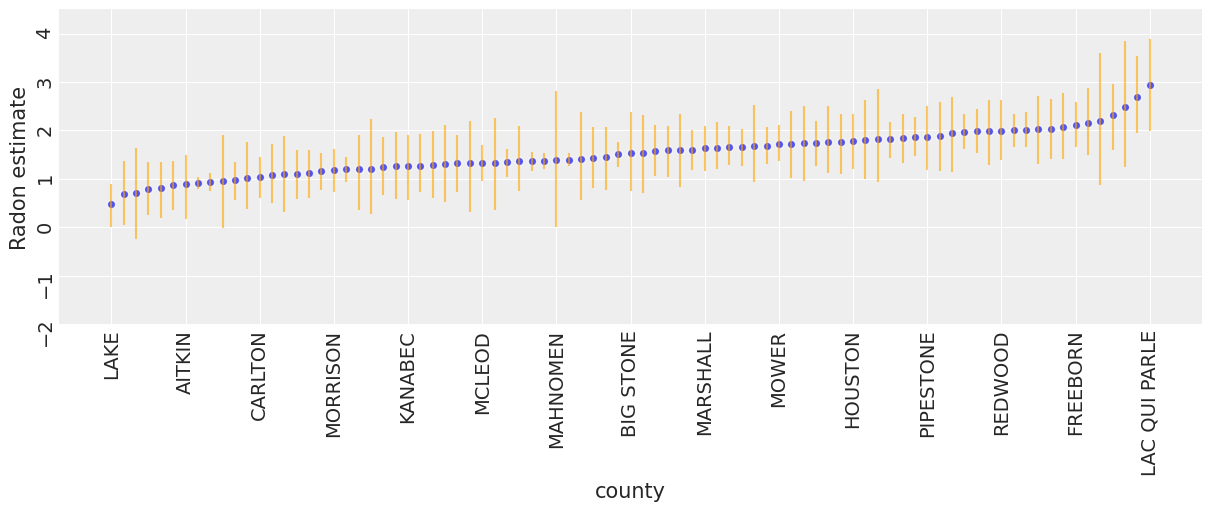

In [82]:
unpooled_means = unpooled_trace.posterior.mean(dim=("chain", "draw"))
unpooled_hdi = az.hdi(unpooled_trace)

unpooled_means_iter = unpooled_means.sortby("alpha")
unpooled_hdi_iter = unpooled_hdi.sortby(unpooled_means_iter.alpha)

_, ax = plt.subplots(figsize=(12, 5))
xticks = np.arange(0, 86, 6)
unpooled_means_iter.plot.scatter(x="county", y="alpha", ax=ax, alpha=0.8)
ax.vlines(
    np.arange(mn_counties.size),
    unpooled_hdi_iter.alpha.sel(hdi="lower"),
    unpooled_hdi_iter.alpha.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
)
ax.set(ylabel="Radon estimate", ylim=(-2, 4.5))
ax.set_xticks(xticks)
ax.set_xticklabels(unpooled_means_iter.county.values[xticks])
ax.tick_params(rotation=90);

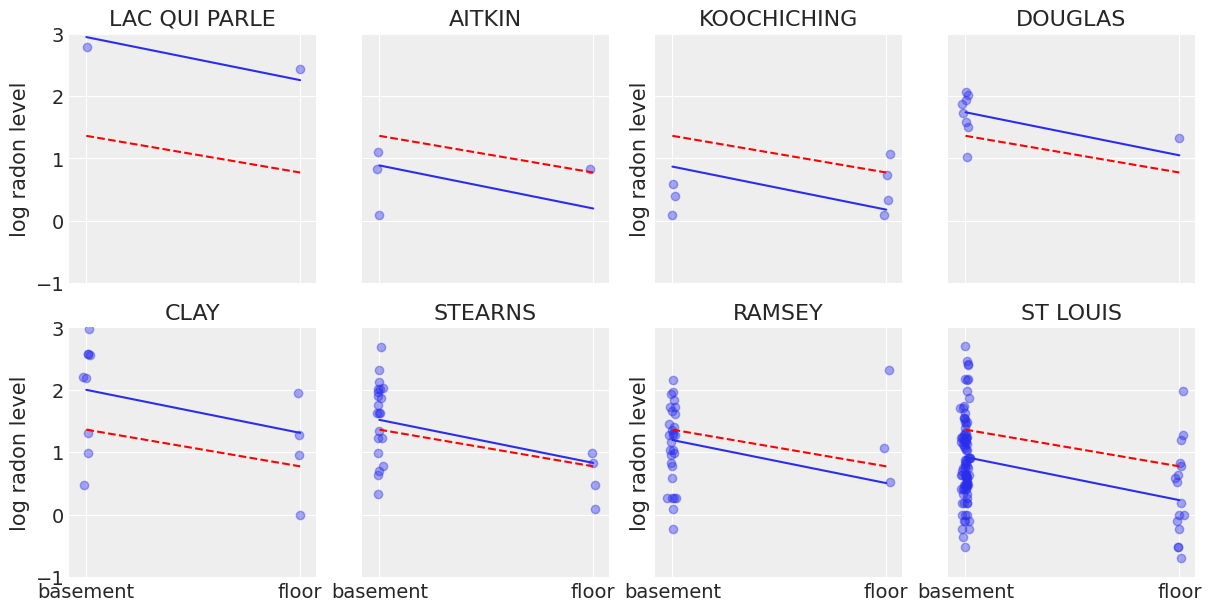

In [83]:
sample_counties = (
    "LAC QUI PARLE",
    "AITKIN",
    "KOOCHICHING",
    "DOUGLAS",
    "CLAY",
    "STEARNS",
    "RAMSEY",
    "ST LOUIS",
)

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_means["beta"]
for i, c in enumerate(sample_counties):
    y = srrs_mn.log_radon[srrs_mn.county == c]
    x = srrs_mn.floor[srrs_mn.county == c]
    axes[i].scatter(x + np.random.randn(len(x)) * 0.01, y, alpha=0.4)

    # No pooling model
    b = unpooled_means["alpha"].sel(county=c)

    # Plot both models and data
    xvals = xr.DataArray(np.linspace(0, 1))
    axes[i].plot(xvals, m * xvals + b)
    axes[i].plot(xvals, post_mean["beta"] * xvals + post_mean["alpha"], "r--")
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["basement", "floor"])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i % 2:
        axes[i].set_ylabel("log radon level")

## Hierachical Models

### Partial Pooling Model

In [84]:
with pm.Model(coords=coords) as partial_pooling:
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10)
    sigma_a = pm.Exponential("sigma_a", 1)

    # Random intercepts
    alpha = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="county")

    # Model error
    sigma_y = pm.Exponential("sigma_y", 1)

    # Expected value
    y_hat = alpha[county_idx]

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_radon, dims="obs_id")

/usr/local/lib/python3.10/dist-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


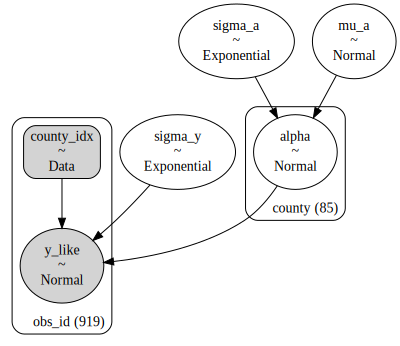

In [85]:
pm.model_to_graphviz(partial_pooling)

In [86]:
with partial_pooling:
    partial_pooling_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Output()

Output()

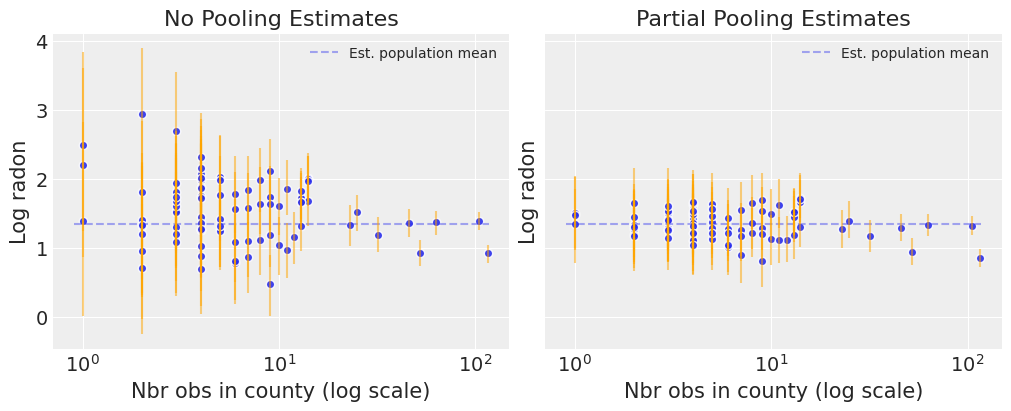

In [87]:
N_county = srrs_mn.groupby("county")["idnum"].count().values

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for ax, trace, level in zip(
    axes,
    (unpooled_trace, partial_pooling_trace),
    ("no pooling", "partial pooling"),
):
    # add variable with x values to xarray dataset
    trace.posterior = trace.posterior.assign_coords({"N_county": ("county", N_county)})
    # plot means
    trace.posterior.mean(dim=("chain", "draw")).plot.scatter(
        x="N_county", y="alpha", ax=ax, alpha=0.9
    )
    ax.hlines(
        partial_pooling_trace.posterior.alpha.mean(),
        0.9,
        max(N_county) + 1,
        alpha=0.4,
        ls="--",
        label="Est. population mean",
    )

    # plot hdi
    hdi = az.hdi(trace).alpha
    ax.vlines(N_county, hdi.sel(hdi="lower"), hdi.sel(hdi="higher"), color="orange", alpha=0.5)

    ax.set(
        title=f"{level.title()} Estimates",
        xlabel="Nbr obs in county (log scale)",
        xscale="log",
        ylabel="Log radon",
    )
    ax.legend(fontsize=10)

### Varying intercept model

In [88]:
with pm.Model(coords=coords) as varying_intercept:
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1)

    # Random intercepts
    alpha = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="county")
    # Common slope
    beta = pm.Normal("beta", mu=0.0, sigma=10.0)

    # Model error
    sd_y = pm.Exponential("sd_y", 1)

    # Expected value
    y_hat = alpha[county_idx] + beta * floor_idx

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sd_y, observed=log_radon, dims="obs_id")

/usr/local/lib/python3.10/dist-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


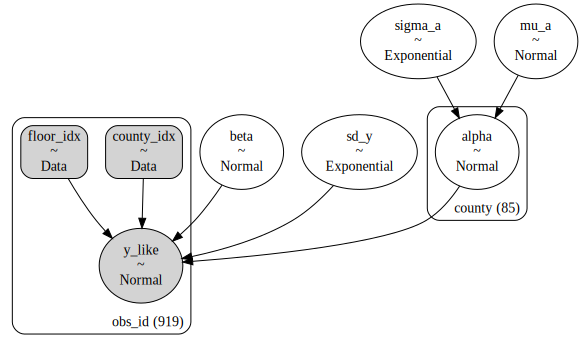

In [89]:
pm.model_to_graphviz(varying_intercept)

In [90]:
with varying_intercept:
    varying_intercept_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Output()

Output()

Text(0, 0.5, 'alpha')

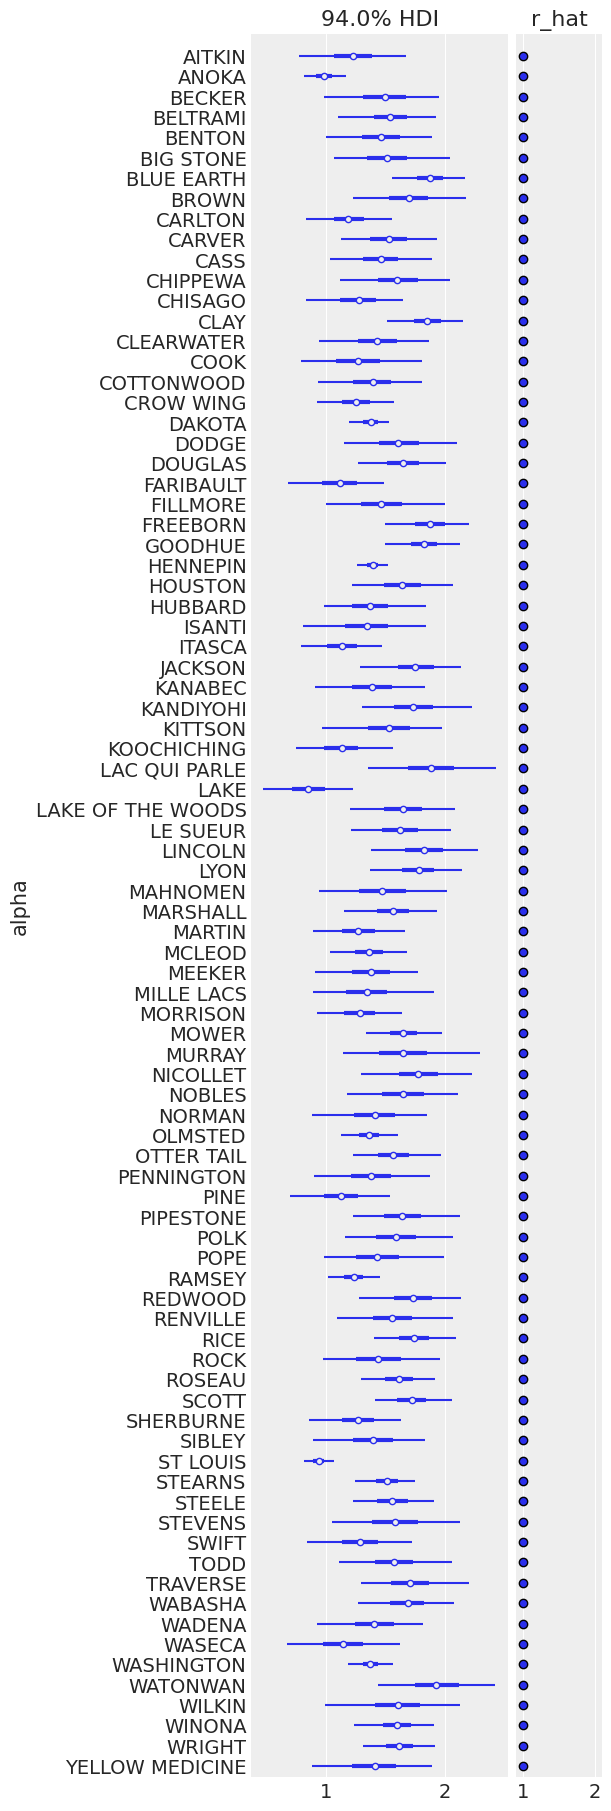

In [91]:
ax = pm.plot_forest(
    varying_intercept_trace,
    var_names=["alpha"],
    figsize=(6, 18),
    combined=True,
    r_hat=True,
    labeller=az.labels.NoVarLabeller(),
)
ax[0].set_ylabel("alpha")

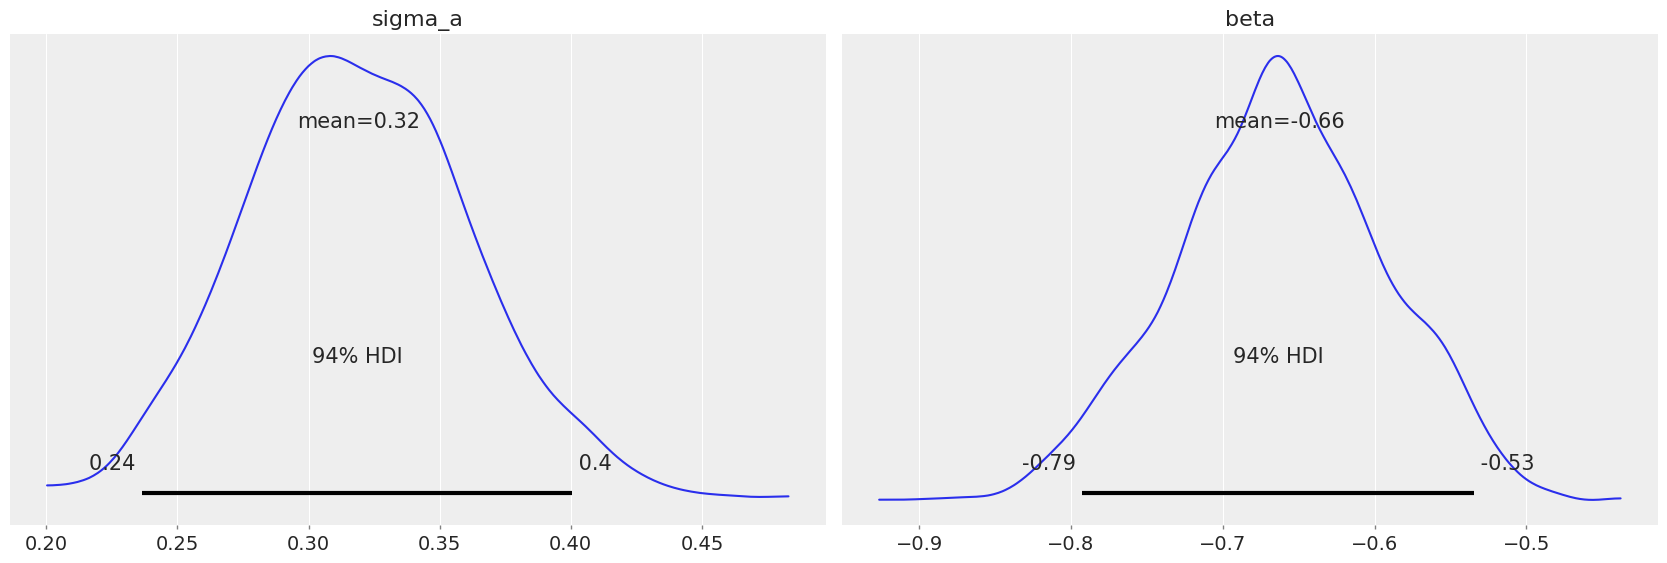

In [92]:
pm.plot_posterior(varying_intercept_trace, var_names=["sigma_a", "beta"]);

In [93]:
az.summary(varying_intercept_trace, var_names=["beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,-0.663,0.07,-0.793,-0.534,0.002,0.001,1267.0,1414.0,1.0


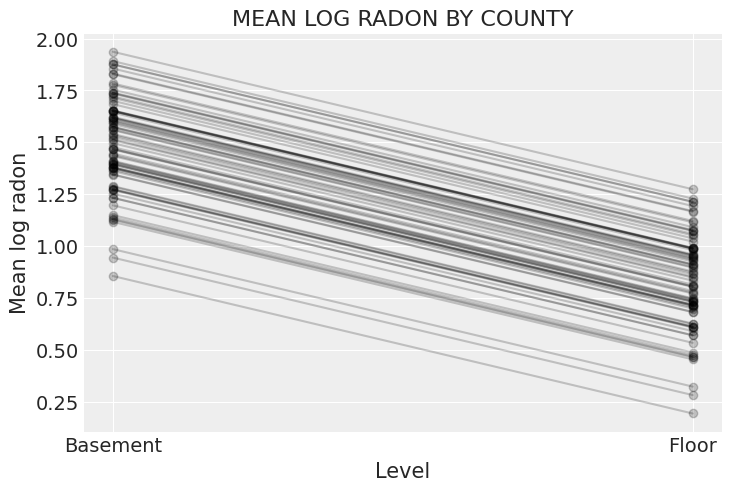

In [94]:
xvals = xr.DataArray([0, 1], dims="Level", coords={"Level": ["Basement", "Floor"]})
post = varying_intercept_trace.posterior  # alias for readability
theta = (
    (post.alpha + post.beta * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean log radon")
)

_, ax = plt.subplots()
theta.plot.scatter(x="Level", y="Mean log radon", alpha=0.2, color="k", ax=ax)  # scatter
ax.plot(xvals, theta["Mean log radon"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("MEAN LOG RADON BY COUNTY");

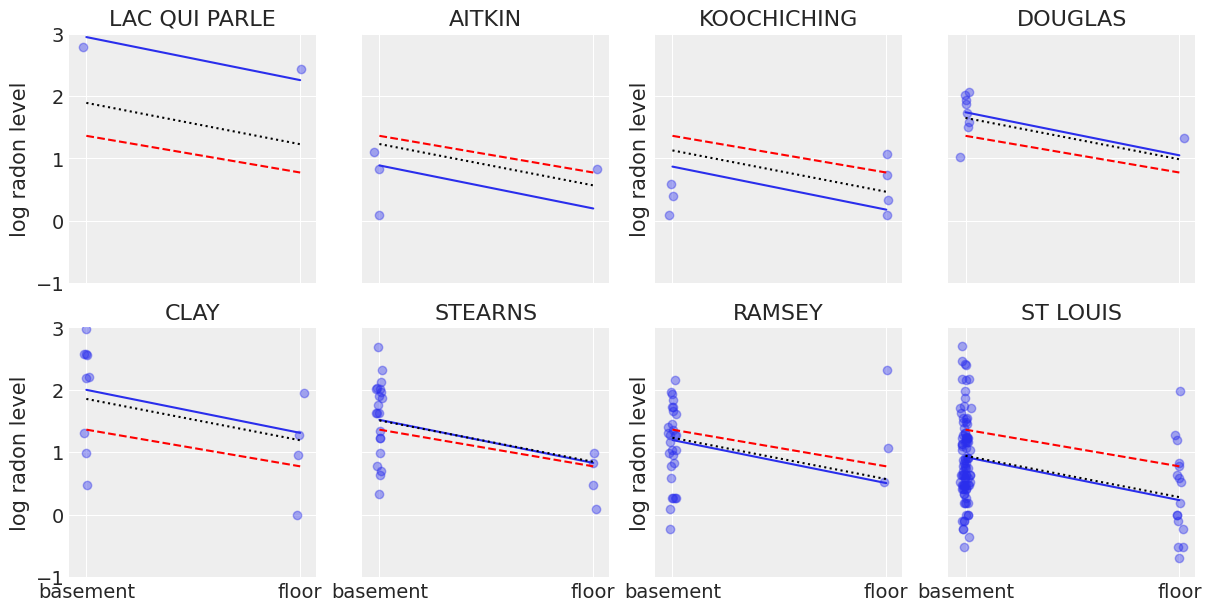

In [95]:
sample_counties = (
    "LAC QUI PARLE",
    "AITKIN",
    "KOOCHICHING",
    "DOUGLAS",
    "CLAY",
    "STEARNS",
    "RAMSEY",
    "ST LOUIS",
)

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_means["beta"]
for i, c in enumerate(sample_counties):
    y = srrs_mn.log_radon[srrs_mn.county == c]
    x = srrs_mn.floor[srrs_mn.county == c]
    axes[i].scatter(x + np.random.randn(len(x)) * 0.01, y, alpha=0.4)

    # No pooling model
    b = unpooled_means["alpha"].sel(county=c)

    # Plot both models and data
    xvals = xr.DataArray(np.linspace(0, 1))
    axes[i].plot(xvals, m.values * xvals + b.values)
    axes[i].plot(xvals, post_mean["beta"] * xvals + post_mean["alpha"], "r--")

    varying_intercept_trace.posterior.sel(county=c).beta
    post = varying_intercept_trace.posterior.sel(county=c).mean(dim=("chain", "draw"))
    theta = post.alpha.values + post.beta.values * xvals
    axes[i].plot(xvals, theta, "k:")
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["basement", "floor"])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i % 2:
        axes[i].set_ylabel("log radon level")

### Varying intercept and slope model

In [96]:
with pm.Model(coords=coords) as varying_intercept_slope:
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1)

    mu_b = pm.Normal("mu_b", mu=0.0, sigma=10.0)
    sigma_b = pm.Exponential("sigma_b", 1)

    # Random intercepts
    alpha = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="county")
    # Random slopes
    beta = pm.Normal("beta", mu=mu_b, sigma=sigma_b, dims="county")

    # Model error
    sigma_y = pm.Exponential("sigma_y", 1)

    # Expected value
    y_hat = alpha[county_idx] + beta[county_idx] * floor_idx

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_radon, dims="obs_id")

/usr/local/lib/python3.10/dist-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


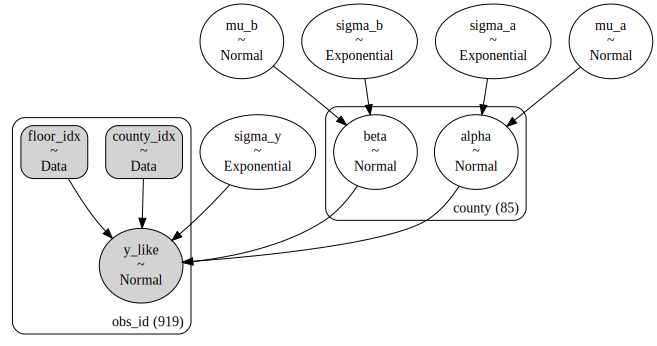

In [97]:
pm.model_to_graphviz(varying_intercept_slope)

In [98]:
with varying_intercept_slope:
    varying_intercept_slope_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Output()

Output()

ERROR:pymc.stats.convergence:There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Non-centered Parameterization

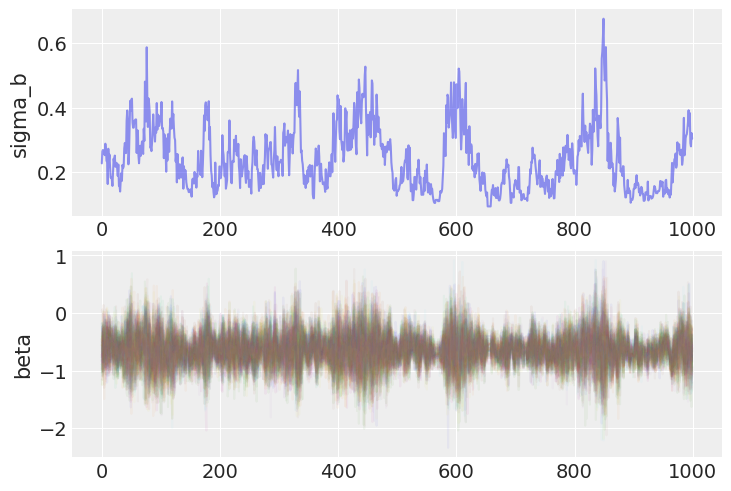

In [99]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(varying_intercept_slope_trace.posterior.sel(chain=0)["sigma_b"], alpha=0.5)
axs[0].set(ylabel="sigma_b")
axs[1].plot(varying_intercept_slope_trace.posterior.sel(chain=0)["beta"], alpha=0.05)
axs[1].set(ylabel="beta");

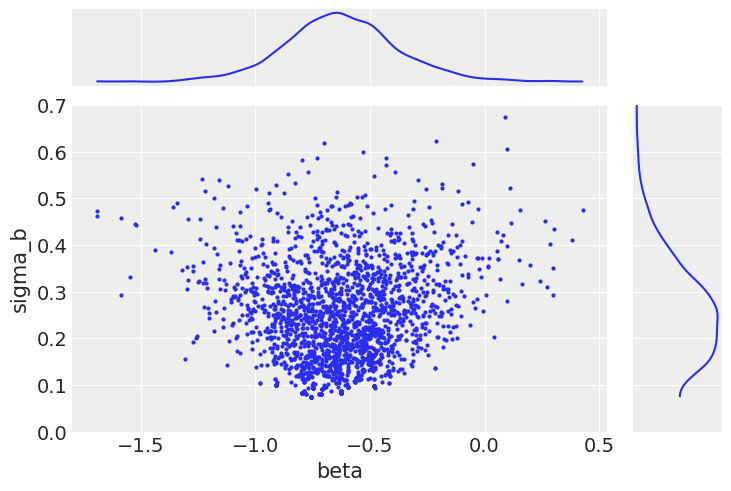

In [100]:
ax = az.plot_pair(
    varying_intercept_slope_trace,
    var_names=["beta", "sigma_b"],
    coords=dict(county="AITKIN"),
    marginals=True,
    # marginal_kwargs={"kind": "hist"},
)
ax[1, 0].set_ylim(0, 0.7);

In [101]:
with pm.Model(coords=coords) as varying_intercept_slope_noncentered:
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 5)

    # Non-centered random intercepts
    # Centered: a = pm.Normal('a', mu_a, sigma=sigma_a, shape=counties)
    z_a = pm.Normal("z_a", mu=0, sigma=1, dims="county")
    alpha = pm.Deterministic("alpha", mu_a + z_a * sigma_a, dims="county")

    mu_b = pm.Normal("mu_b", mu=0.0, sigma=10.0)
    sigma_b = pm.Exponential("sigma_b", 5)

    # Non-centered random slopes
    z_b = pm.Normal("z_b", mu=0, sigma=1, dims="county")
    beta = pm.Deterministic("beta", mu_b + z_b * sigma_b, dims="county")

    # Model error
    sigma_y = pm.Exponential("sigma_y", 5)

    # Expected value
    y_hat = alpha[county_idx] + beta[county_idx] * floor_idx

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_radon, dims="obs_id")

/usr/local/lib/python3.10/dist-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


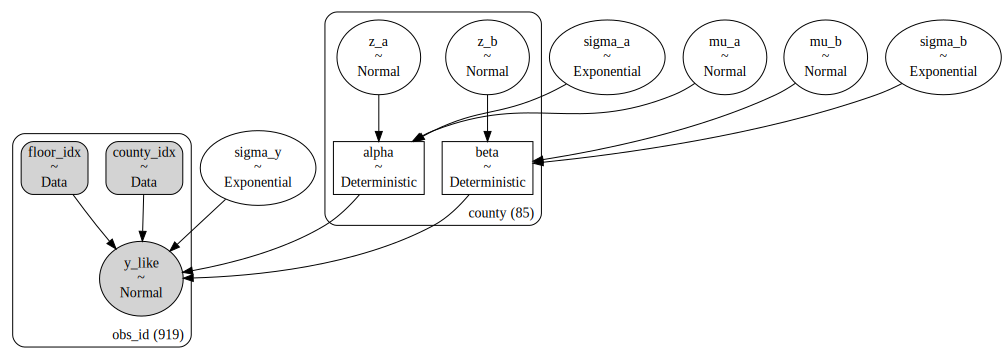

In [102]:
pm.model_to_graphviz(varying_intercept_slope_noncentered)

In [103]:
with varying_intercept_slope_noncentered:
    noncentered_trace = pm.sample(tune=3000, target_accept=0.95, random_seed=RANDOM_SEED)

Output()

Output()

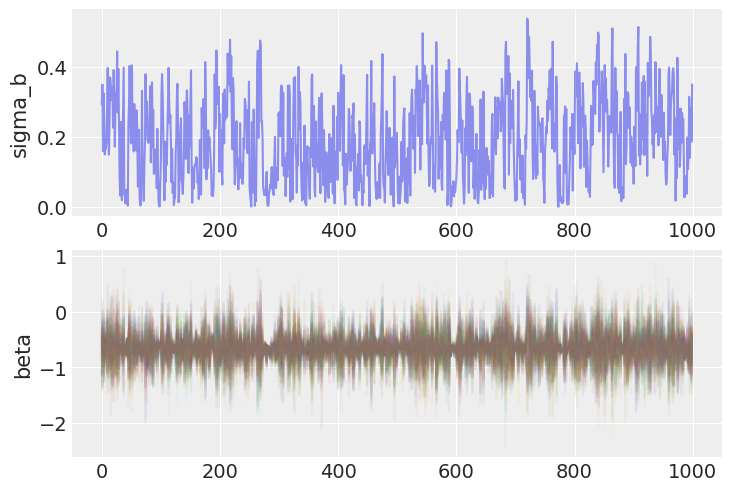

In [104]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(noncentered_trace.posterior.sel(chain=0)["sigma_b"], alpha=0.5)
axs[0].set(ylabel="sigma_b")
axs[1].plot(noncentered_trace.posterior.sel(chain=0)["beta"], alpha=0.05)
axs[1].set(ylabel="beta");

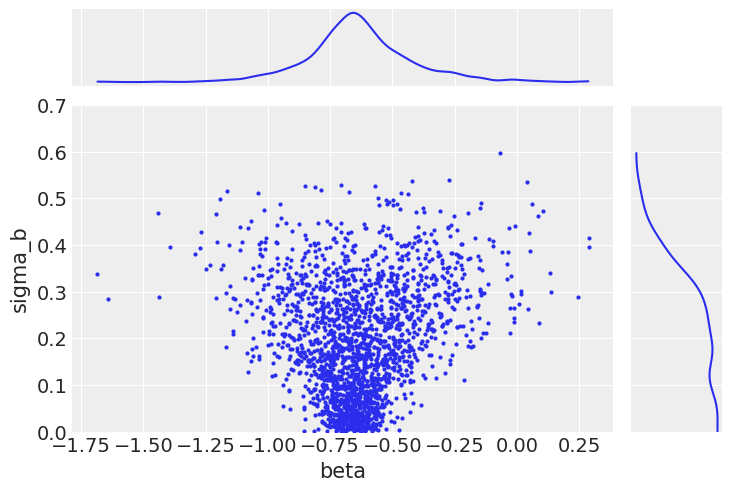

In [105]:
ax = az.plot_pair(
    noncentered_trace,
    var_names=["beta", "sigma_b"],
    coords=dict(county="AITKIN"),
    marginals=True,
    # marginal_kwargs={"kind": "hist"},
)
ax[1, 0].set_ylim(0, 0.7);

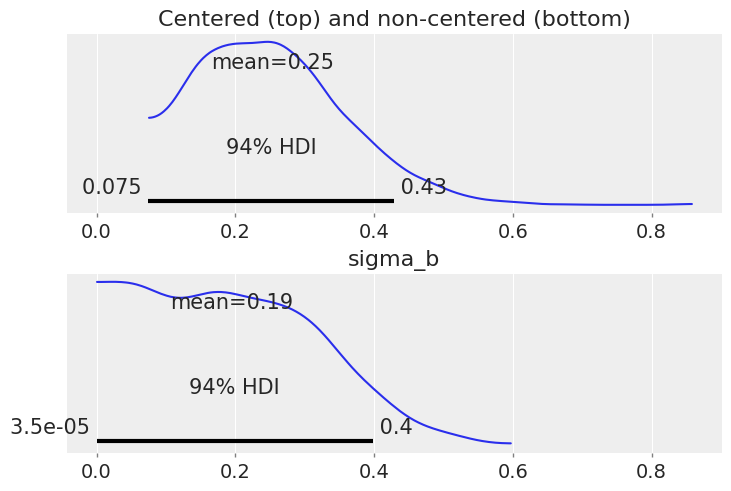

In [106]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, constrained_layout=True)
az.plot_posterior(varying_intercept_slope_trace, var_names=["sigma_b"], ax=ax1)
az.plot_posterior(noncentered_trace, var_names=["sigma_b"], ax=ax2)
ax1.set_title("Centered (top) and non-centered (bottom)");

In [107]:
az.summary(varying_intercept_slope_trace, var_names=["sigma_a", "sigma_b"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_a,0.322,0.042,0.239,0.400,0.002,0.001,522.0,895.0,1.00
sigma_b,0.253,0.105,0.075,0.429,0.013,0.010,54.0,55.0,1.05


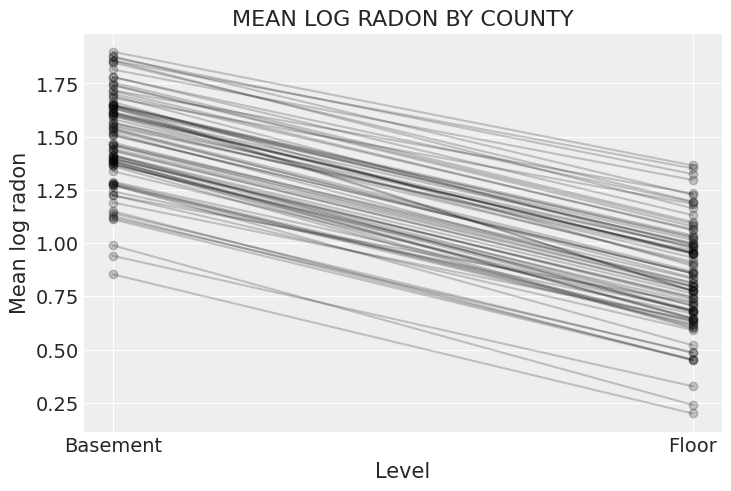

In [108]:
xvals = xr.DataArray([0, 1], dims="Level", coords={"Level": ["Basement", "Floor"]})
post = noncentered_trace.posterior  # alias for readability
theta = (
    (post.alpha + post.beta * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean log radon")
)

_, ax = plt.subplots()
theta.plot.scatter(x="Level", y="Mean log radon", alpha=0.2, color="k", ax=ax)  # scatter
ax.plot(xvals, theta["Mean log radon"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("MEAN LOG RADON BY COUNTY");

In [109]:
coords["param"] = ["alpha", "beta"]
coords["param_bis"] = ["alpha", "beta"]
with pm.Model(coords=coords) as covariation_intercept_slope:
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # prior stddev in intercepts & slopes (variation across counties):
    sd_dist = pm.Exponential.dist(0.5, shape=(2,))

    # get back standard deviations and rho:
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=2.0, sd_dist=sd_dist)

    # prior for average intercept:
    mu_alpha_beta = pm.Normal("mu_alpha", mu=0.0, sigma=5.0, shape=2)
    # prior for average slope:
    mu_beta = pm.Normal("mu_beta", mu=0.0, sigma=1.0)
    # population of varying effects:
    alpha_beta_county = pm.MvNormal(
        "alpha_beta_county", mu=mu_alpha_beta, chol=chol, dims=("county", "param")
    )

    # Expected value per county:
    theta = alpha_beta_county[county_idx, 0] + alpha_beta_county[county_idx, 1] * floor_idx
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

/usr/local/lib/python3.10/dist-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [110]:
coords["param"] = ["alpha", "beta"]
coords["param_bis"] = ["alpha", "beta"]
with pm.Model(coords=coords) as covariation_intercept_slope:
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # prior stddev in intercepts & slopes (variation across counties):
    sd_dist = pm.Exponential.dist(0.5, shape=(2,))

    # get back standard deviations and rho:
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=2.0, sd_dist=sd_dist)

    # priors for average intercept and slope:
    mu_alpha_beta = pm.Normal("mu_alpha_beta", mu=0.0, sigma=5.0, shape=2)

    # population of varying effects:
    z = pm.Normal("z", 0.0, 1.0, dims=("param", "county"))
    alpha_beta_county = pm.Deterministic(
        "alpha_beta_county", pt.dot(chol, z).T, dims=("county", "param")
    )

    # Expected value per county:
    theta = (
        mu_alpha_beta[0]
        + alpha_beta_county[county_idx, 0]
        + (mu_alpha_beta[1] + alpha_beta_county[county_idx, 1]) * floor_idx
    )

    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

    covariation_intercept_slope_trace = pm.sample(
        1000,
        tune=3000,
        target_accept=0.95,
        idata_kwargs={"dims": {"chol_stds": ["param"], "chol_corr": ["param", "param_bis"]}},
    )

/usr/local/lib/python3.10/dist-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Output()

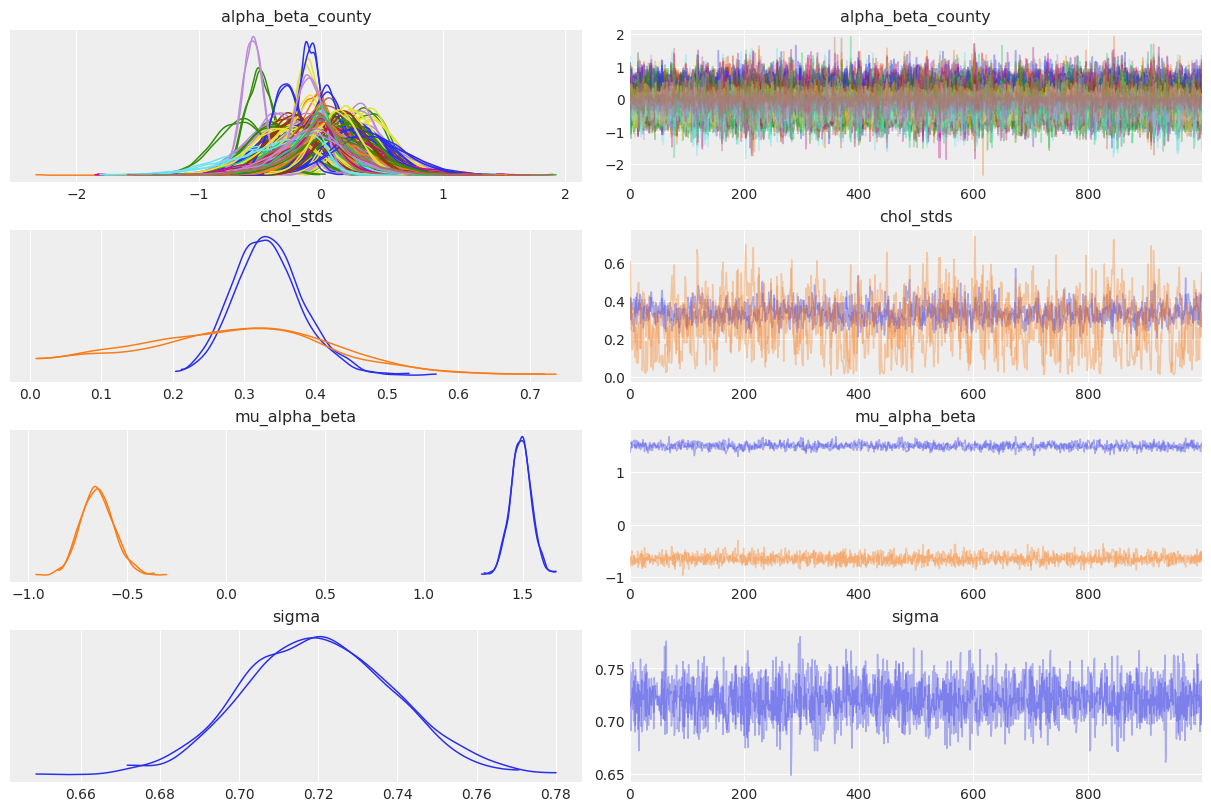

In [111]:
az.plot_trace(
    covariation_intercept_slope_trace,
    var_names=["~z", "~chol", "~chol_corr"],
    compact=True,
    chain_prop={"ls": "-"},
);

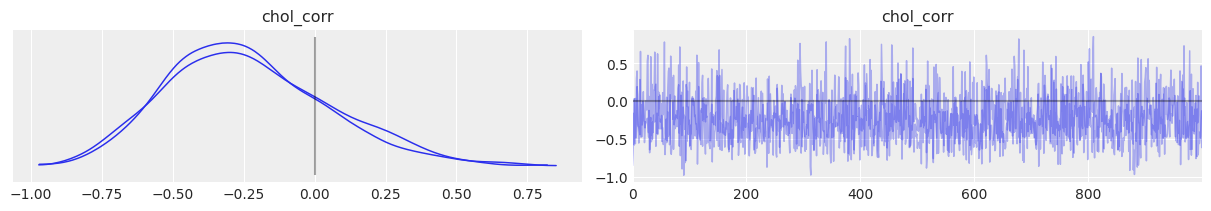

In [112]:
az.plot_trace(
    covariation_intercept_slope_trace,
    var_names="chol_corr",
    lines=[("chol_corr", {}, 0.0)],
    compact=True,
    chain_prop={"ls": "-"},
    coords={
        "param": xr.DataArray(["alpha"], dims=["pointwise_sel"]),
        "param_bis": xr.DataArray(["beta"], dims=["pointwise_sel"]),
    },
);

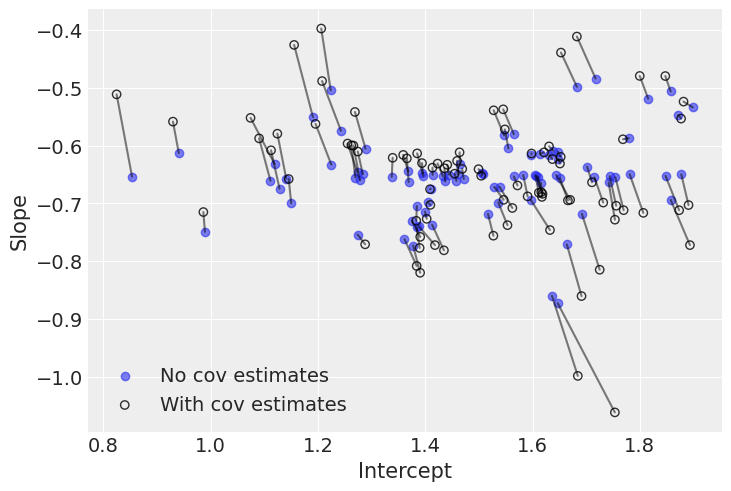

In [113]:
# posterior means of covariation model:
a_county_cov = (
    covariation_intercept_slope_trace.posterior["mu_alpha_beta"][..., 0]
    + covariation_intercept_slope_trace.posterior["alpha_beta_county"].sel(param="alpha")
).mean(dim=("chain", "draw"))
b_county_cov = (
    covariation_intercept_slope_trace.posterior["mu_alpha_beta"][..., 1]
    + covariation_intercept_slope_trace.posterior["alpha_beta_county"].sel(param="beta")
).mean(dim=("chain", "draw"))

# plot both and connect with lines
avg_a_county = noncentered_trace.posterior["alpha"].mean(dim=("chain", "draw"))
avg_b_county = noncentered_trace.posterior["beta"].mean(dim=("chain", "draw"))
plt.scatter(avg_a_county, avg_b_county, label="No cov estimates", alpha=0.6)
plt.scatter(
    a_county_cov,
    b_county_cov,
    facecolors="none",
    edgecolors="k",
    lw=1,
    label="With cov estimates",
    alpha=0.8,
)
plt.plot([avg_a_county, a_county_cov], [avg_b_county, b_county_cov], "k-", alpha=0.5)
plt.xlabel("Intercept")
plt.ylabel("Slope")
plt.legend();

### Adding group-level predictors

In [114]:
with pm.Model(coords=coords) as hierarchical_intercept:
    # Priors
    sigma_a = pm.HalfCauchy("sigma_a", 5)

    # County uranium model
    gamma_0 = pm.Normal("gamma_0", mu=0.0, sigma=10.0)
    gamma_1 = pm.Normal("gamma_1", mu=0.0, sigma=10.0)

    # Uranium model for intercept
    mu_a = pm.Deterministic("mu_a", gamma_0 + gamma_1 * u)
    # County variation not explained by uranium
    epsilon_a = pm.Normal("epsilon_a", mu=0, sigma=1, dims="county")
    alpha = pm.Deterministic("alpha", mu_a + sigma_a * epsilon_a, dims="county")

    # Common slope
    beta = pm.Normal("beta", mu=0.0, sigma=10.0)

    # Model error
    sigma_y = pm.Uniform("sigma_y", lower=0, upper=100)

    # Expected value
    y_hat = alpha[county] + beta * floor_measure

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_radon)

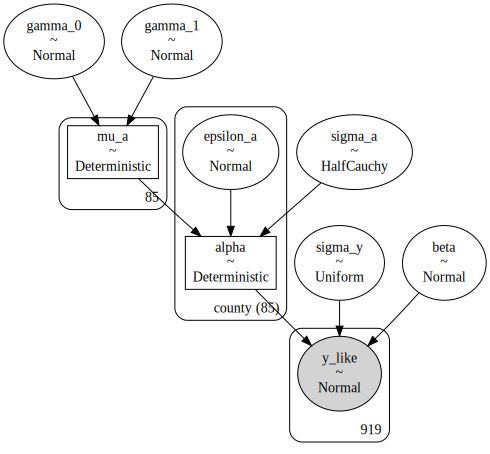

In [115]:
pm.model_to_graphviz(hierarchical_intercept)

In [116]:
with hierarchical_intercept:
    hierarchical_intercept_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Output()

Output()

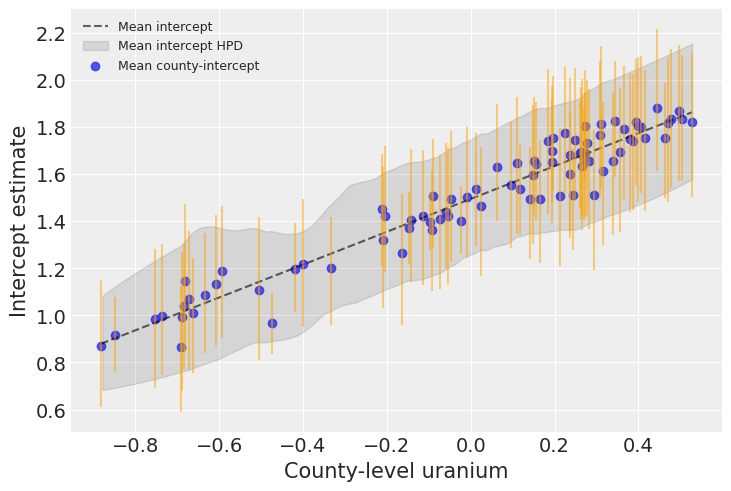

In [117]:
uranium = u
post = hierarchical_intercept_trace.posterior.assign_coords(uranium=uranium)
avg_a = post["mu_a"].mean(dim=("chain", "draw")).values[np.argsort(uranium)]
avg_a_county = post["alpha"].mean(dim=("chain", "draw"))
avg_a_county_hdi = az.hdi(post, var_names="alpha")["alpha"]

_, ax = plt.subplots()
ax.plot(uranium[np.argsort(uranium)], avg_a, "k--", alpha=0.6, label="Mean intercept")
az.plot_hdi(
    uranium,
    post["alpha"],
    fill_kwargs={"alpha": 0.1, "color": "k", "label": "Mean intercept HPD"},
    ax=ax,
)
ax.scatter(uranium, avg_a_county, alpha=0.8, label="Mean county-intercept")
ax.vlines(
    uranium,
    avg_a_county_hdi.sel(hdi="lower"),
    avg_a_county_hdi.sel(hdi="higher"),
    alpha=0.5,
    color="orange",
)
plt.xlabel("County-level uranium")
plt.ylabel("Intercept estimate")
plt.legend(fontsize=9);

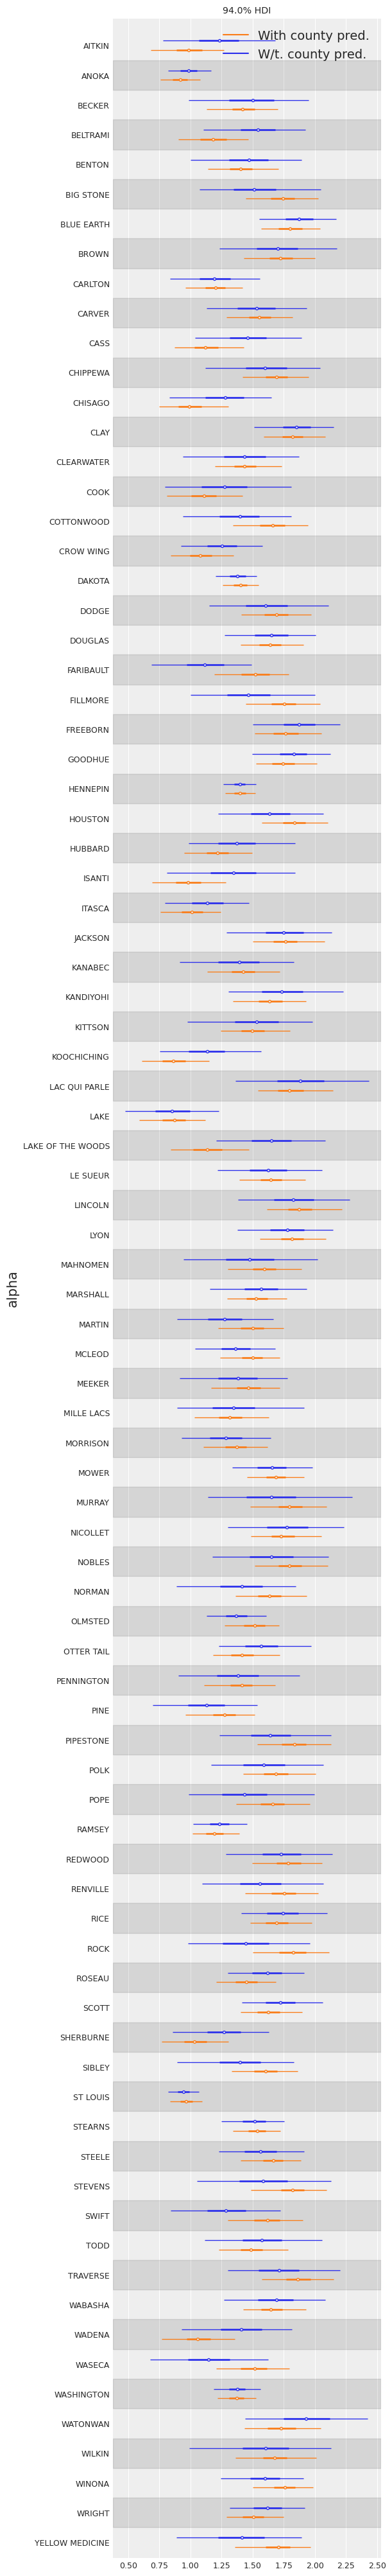

In [118]:
labeller = az.labels.mix_labellers((az.labels.NoVarLabeller, az.labels.NoModelLabeller))
ax = az.plot_forest(
    [varying_intercept_trace, hierarchical_intercept_trace],
    model_names=["W/t. county pred.", "With county pred."],
    var_names=["alpha"],
    combined=True,
    figsize=(6, 40),
    textsize=9,
    labeller=labeller(),
)
ax[0].set_ylabel("alpha");

## Correlations among levels

In [119]:
# Create new variable for mean of floor across counties
avg_floor_data = srrs_mn.groupby("county")["floor"].mean().values

In [120]:
with pm.Model(coords=coords) as contextual_effect:
    floor_idx = pm.Data("floor_idx", floor_measure, mutable=True)
    county_idx = pm.Data("county_idx", county, mutable=True)
    y = pm.Data("y", log_radon, mutable=True)

    # Priors
    sigma_a = pm.HalfCauchy("sigma_a", 5)

    # County uranium model for slope
    gamma = pm.Normal("gamma", mu=0.0, sigma=10, shape=3)

    # Uranium model for intercept
    mu_a = pm.Deterministic("mu_a", gamma[0] + gamma[1] * u + gamma[2] * avg_floor_data)

    # County variation not explained by uranium
    epsilon_a = pm.Normal("epsilon_a", mu=0, sigma=1, dims="county")
    alpha = pm.Deterministic("alpha", mu_a + sigma_a * epsilon_a)

    # Common slope
    beta = pm.Normal("beta", mu=0.0, sigma=10)

    # Model error
    sigma_y = pm.Uniform("sigma_y", lower=0, upper=100)

    # Expected value
    y_hat = alpha[county_idx] + beta * floor_idx

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=y)

/usr/local/lib/python3.10/dist-packages/pymc/data.py:440: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


In [121]:
with contextual_effect:
    contextual_effect_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Output()

Output()

In [122]:
az.summary(contextual_effect_trace, var_names="gamma", round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma[0],1.43,0.05,1.33,1.52,0.0,0.0,1687.01,1505.06,1.0
gamma[1],0.70,0.09,0.52,0.86,0.0,0.0,2516.10,1466.95,1.0
gamma[2],0.39,0.20,0.05,0.77,0.0,0.0,2371.66,1639.91,1.0


In [123]:
prediction_coords = {"obs_id": ["ST LOUIS", "KANABEC"]}
with contextual_effect:
    pm.set_data({"county_idx": np.array([69, 31]), "floor_idx": np.array([1, 1]), "y": np.ones(2)})
    stl_pred = pm.sample_posterior_predictive(contextual_effect_trace.posterior)

contextual_effect_trace.extend(stl_pred)

Output()

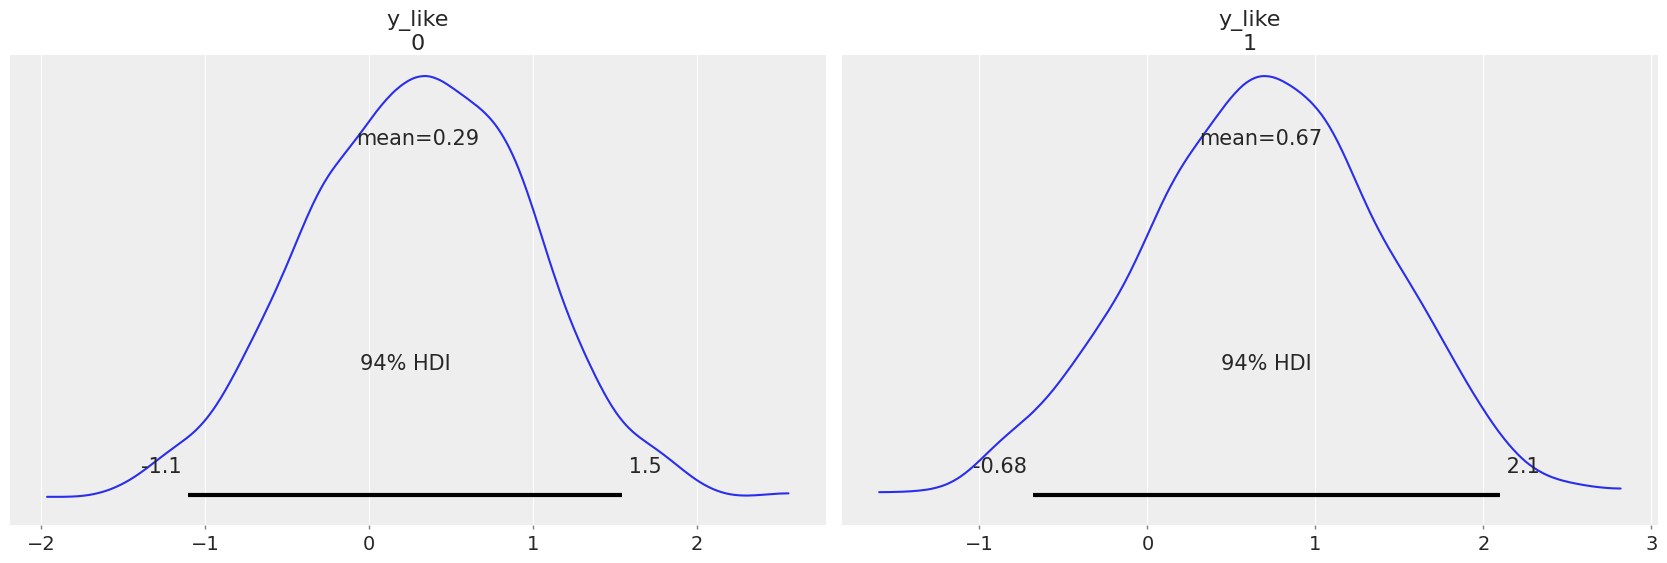

In [124]:
az.plot_posterior(contextual_effect_trace, group="posterior_predictive");

## Property Value Exploration

In [125]:

# Dati sintetici di esempio
n_province = 10  # Numero di province
n_immobili = 100  # Numero di immobili

# Dati: forecast a livello provinciale
forecast_prezzi = np.random.normal(200000, 50000, n_province)

# Dati: variazioni attese per caratteristiche
classi_energetiche = np.random.choice(['A', 'B', 'C', 'D'], n_immobili)
rischio_climatico = np.random.choice(['Basso', 'Medio', 'Alto'], n_immobili)

# Codifica numerica delle classi
ce_map = {'A': 1.2, 'B': 1.1, 'C': 0.9, 'D': 0.8}
rc_map = {'Basso': 1.1, 'Medio': 1.0, 'Alto': 0.8}

ce_effect = np.array([ce_map[ce] for ce in classi_energetiche])
rc_effect = np.array([rc_map[rc] for rc in rischio_climatico])



In [131]:
len(ce_effect)

100

In [139]:
# Modello PyMC
with pm.Model() as property_value_model:
    # Prior distribuzione dei prezzi a livello provinciale
    mu_prov = pm.Normal("mu_prov", mu=200000, sigma=50000, shape=n_immobili)

    # Effetto gerarchico di classe energetica
    delta_ce = pm.Normal("delta_classe_energetica", mu=0, sigma=5000)

    # Effetto gerarchico di rischio climatico
    delta_rc = pm.Normal("delta_rischio_climatico", mu=0, sigma=5000)

    # Effetto totale per immobile
    property_value = mu_prov + ce_effect * delta_ce + rc_effect * delta_rc

    # Likelihood (assumendo osservazioni con un rumore normale)
    observed_values = pm.Normal("Property Value", mu=property_value, sigma=10000, observed=np.random.normal(200000, 10000, n_immobili))

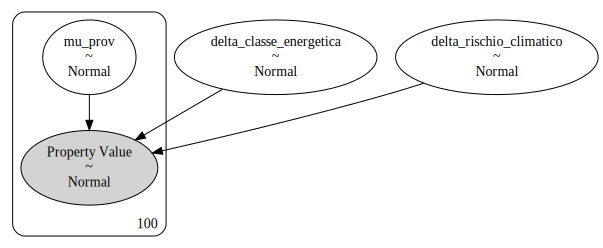

In [140]:
# Generazione del grafico del modello
pm.model_to_graphviz(property_value_model)

In [141]:
with property_value_model:
    property_value_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Output()

Output()

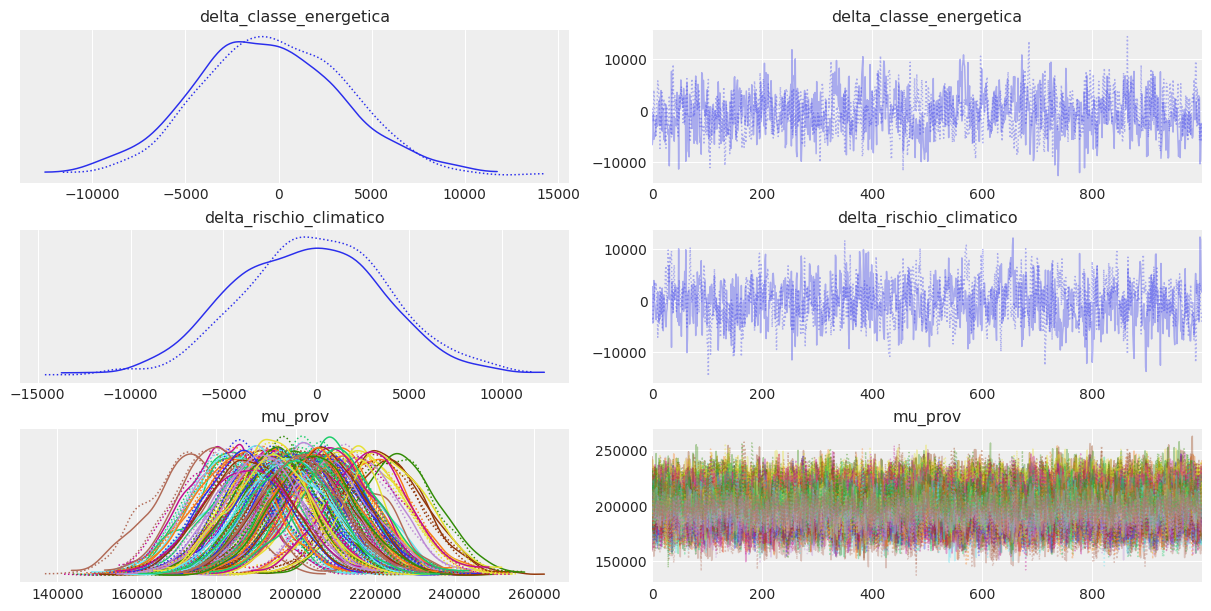

In [142]:
az.plot_trace(
    property_value_trace,
);